In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation


In [2]:
data_dir = script_dir / "original_data"
TRAINING_SAMPLES_FILE = data_dir / "18D_800LHS.dat"
TEST_SAMPLES_FILE = data_dir / "testDakota_18D_100LHS_json.txt"

## Load & process input data

In [3]:
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
TEST_SAMPLES_FILE = shutil.copy(TEST_SAMPLES_FILE, tmp_folder)

In [4]:
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(TRAINING_SAMPLES_FILE)
PROCESSED_TEST_FILE = funs_data_processing.process_input_file(
    TEST_SAMPLES_FILE,
    columns_to_remove=["-AFpeak"],  # remove the output column; needs to be evaluated
)

In [5]:
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)
variables_test = funs_data_processing.get_variable_names(PROCESSED_TEST_FILE)
print(variables_test)

['%eval_id', 'DEPTH', 'DIAMETER', 'ANGLE', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF', '-AFpeak']
['%eval_id', 'DEPTH', 'DIAMETER', 'ANGLE', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF']


## Plot input data (Fig03 & Fig07)

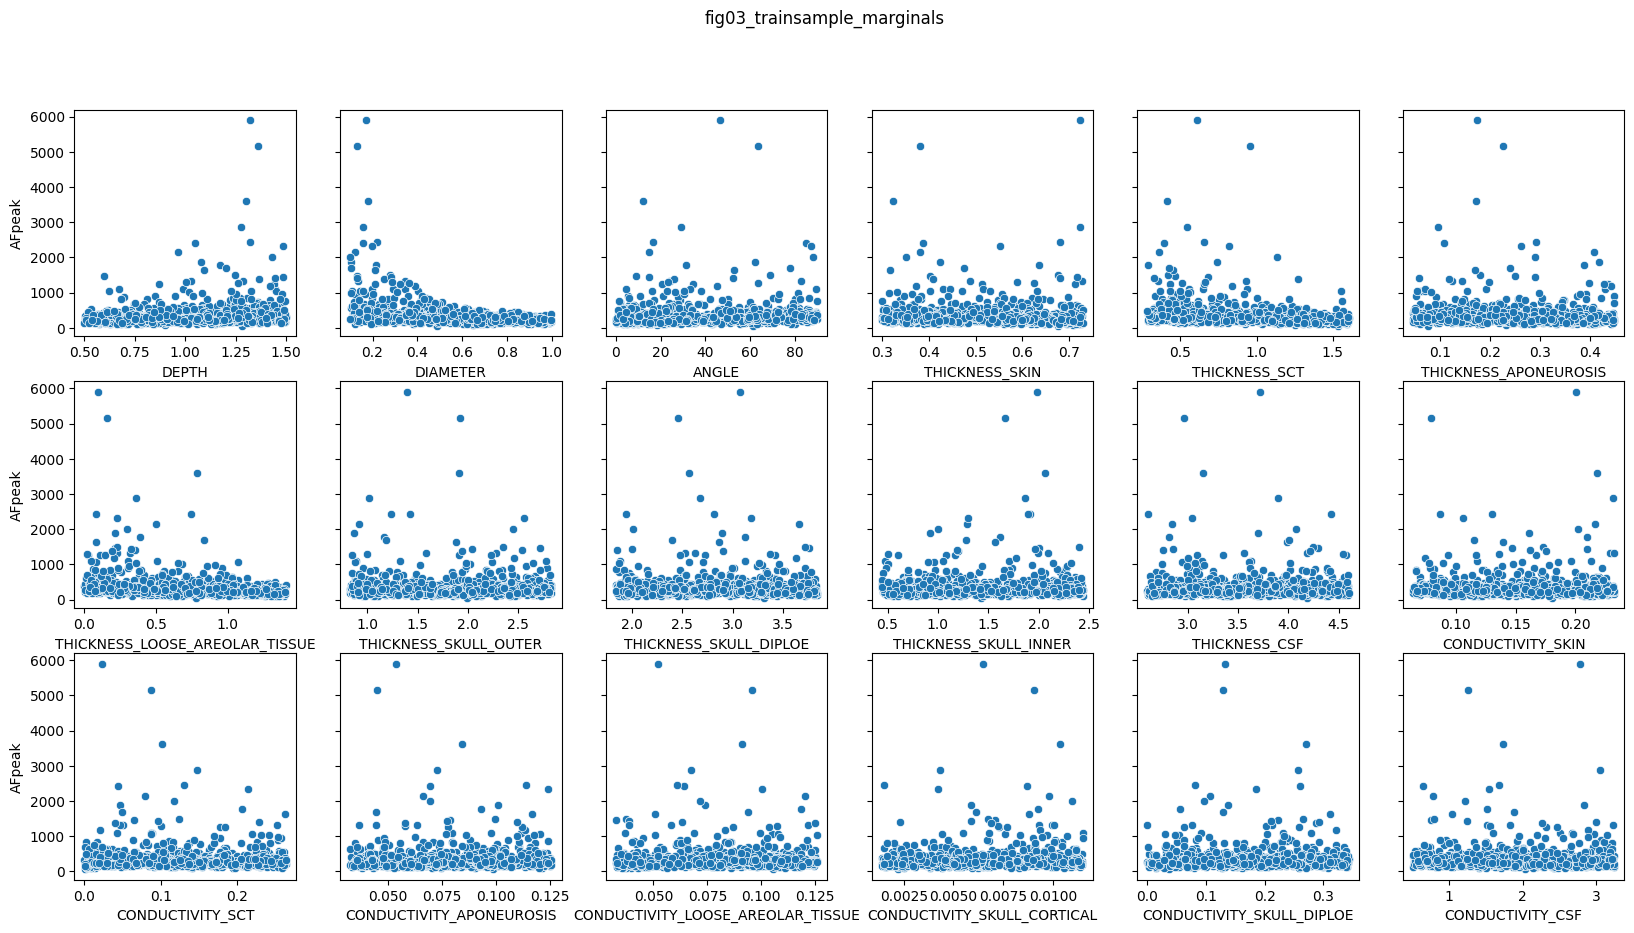

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

title = "fig03_trainsample_marginals"
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
data = funs_data_processing.load_data(PROCESSED_TRAINING_FILE)
data = data.astype(np.float64)
data.rename(columns={"-AFpeak": "AFpeak"}, inplace=True)
data.head()
axs: List[plt.Axes] = axs.flatten()
# fig, axs = plt.subplots(1,1, figsize=(15, 15), sharey=True)
# axs = [axs]
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="AFpeak", ax=ax)
    # plt.scatter(data[c].values, data["AFpeak"].values)
    ax.set_xlabel(c)
    # ax.hlines(0.0, data[c].min(), data[c].max(), color="black", linestyle="--")
plt.suptitle(title)
plt.show()

## Create & run Dakota study

In [14]:
dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE, cross_validation_folds=5
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(PROCESSED_TEST_FILE)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-1],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-1])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                
                cross_validation folds = 5 
                metrics = "root_mean_squared" "sum_abs" "mean_abs" "max_abs" "rsquared"
                
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/18D_800LHS_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo responses!!
      

In [15]:
# os.chdir(tmp_folder)
# study = dakenv.study(
#     callbacks={},  ## DONT NEED ANY MODEL EVALUATIONS
#     input_string=dakota_conf,
# )
# study.execute()
# os.chdir(script_dir)

os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

# import subprocess

# subprocess.run(
#     " ".join(["dakota", "-i", str(dakota_conf_path), "-o", "rest.out"]),
#     shell=True,
#     cwd=tmp_folder,
# )

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Tue Sep  3 17:36:19 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 18 variables and 1 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/18D_800LHS_processed.txt'
Variables read:
                      6.6489938030e-01 DEPTH
                      6.2035560920e-01 DIAMETER
                      5.5224948460e-01 ANGLE
                      5.7754455370e-01 THICKNESS_SKIN
                      1.1670527490e+00 THICKNESS_SCT
                      3.7099138260e-01 THICKNESS_APONEUROSIS
                      1.0019174640e+00 THICKNESS_LOOSE_AREOLAR_TISSUE
              

## Evaluate Dakota predictions

In [9]:
y = funs_data_processing.get_results(TEST_SAMPLES_FILE, "-AFpeak")
y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", "-AFpeak")
std = np.sqrt(
    funs_data_processing.get_results(tmp_folder / "variances.dat", "-AFpeak_variance")
)
y_tilde = (y - y_hat) / std

k =  1.5
The data IS normally distributed. p-value: 0.5330675301231407


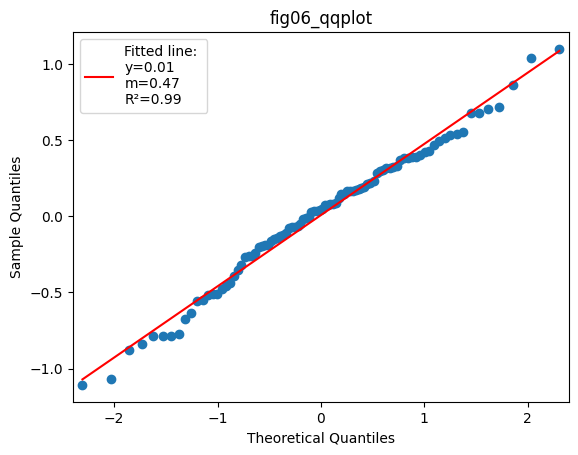

k =  None
The data is NOT normally distributed. p-value: 4.011757006342892e-06


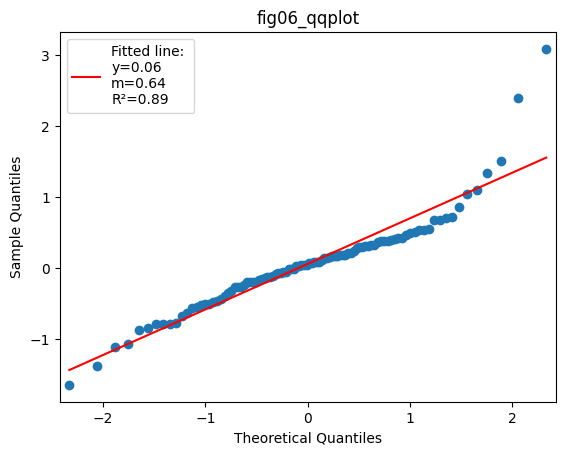

In [10]:
from utils import funs_gp_evaluation
import matplotlib.pyplot as plt

for k in [1.5, None]:  # outlier detection threshold
    print("k = ", k)
    pval = funs_gp_evaluation.test_normality(y_tilde, k)
    slope, intercept, r2 = funs_gp_evaluation.make_qqplot(y_tilde, k, MAKEPLOT=True)
    plt.title("fig06_qqplot")
    plt.show()

In [11]:
data = funs_data_processing.load_data(PROCESSED_TEST_FILE)
data = data.astype(np.float64)
data["y"] = y
data["y_hat"] = y_hat
data["res"] = y - y_hat
data["ares"] = np.abs(y - y_hat)
data["nres"] = y_tilde
data["anres"] = np.abs(y_tilde)
data.head()

,%eval_id,DEPTH,DIAMETER,ANGLE,THICKNESS_SKIN,THICKNESS_SCT,THICKNESS_APONEUROSIS,THICKNESS_LOOSE_AREOLAR_TISSUE,THICKNESS_SKULL_OUTER,THICKNESS_SKULL_DIPLOE,...,CONDUCTIVITY_LOOSE_AREOLAR_TISSUE,CONDUCTIVITY_SKULL_CORTICAL,CONDUCTIVITY_SKULL_DIPLOE,CONDUCTIVITY_CSF,y,y_hat,res,ares,nres,anres
0,1.0,1.222188,0.974598,66.761548,0.614796,0.485372,0.280977,0.338675,2.075335,2.338116,...,0.039706,0.008355,0.089769,1.689141,264.924254,229.031156,35.893098,35.893098,0.218179,0.218179
1,2.0,0.671588,0.279067,1.774902,0.600534,1.272719,0.178890,1.114281,1.011541,3.689802,...,0.058882,0.007882,0.048350,2.827663,139.310069,164.914324,-25.604255,25.604255,-0.151438,0.151438
2,3.0,1.359295,0.534063,44.940273,0.537889,0.435242,0.358683,0.958288,2.269780,2.628797,...,0.089769,0.010152,0.204827,1.570175,411.934585,376.070324,35.864261,35.864261,0.303266,0.303266
3,4.0,1.420433,0.254067,13.134504,0.652785,0.810396,0.421351,0.758754,1.382508,2.213984,...,0.089387,0.009650,0.016710,1.001465,386.306235,412.248657,-25.942423,25.942423,-0.122575,0.122575
4,5.0,1.432626,0.964514,59.059853,0.527910,1.016877,0.207947,0.696071,1.443457,3.082507,...,0.119182,0.005639,0.103415,2.691786,284.180785,344.976176,-60.795390,60.795390,-0.261772,0.261772


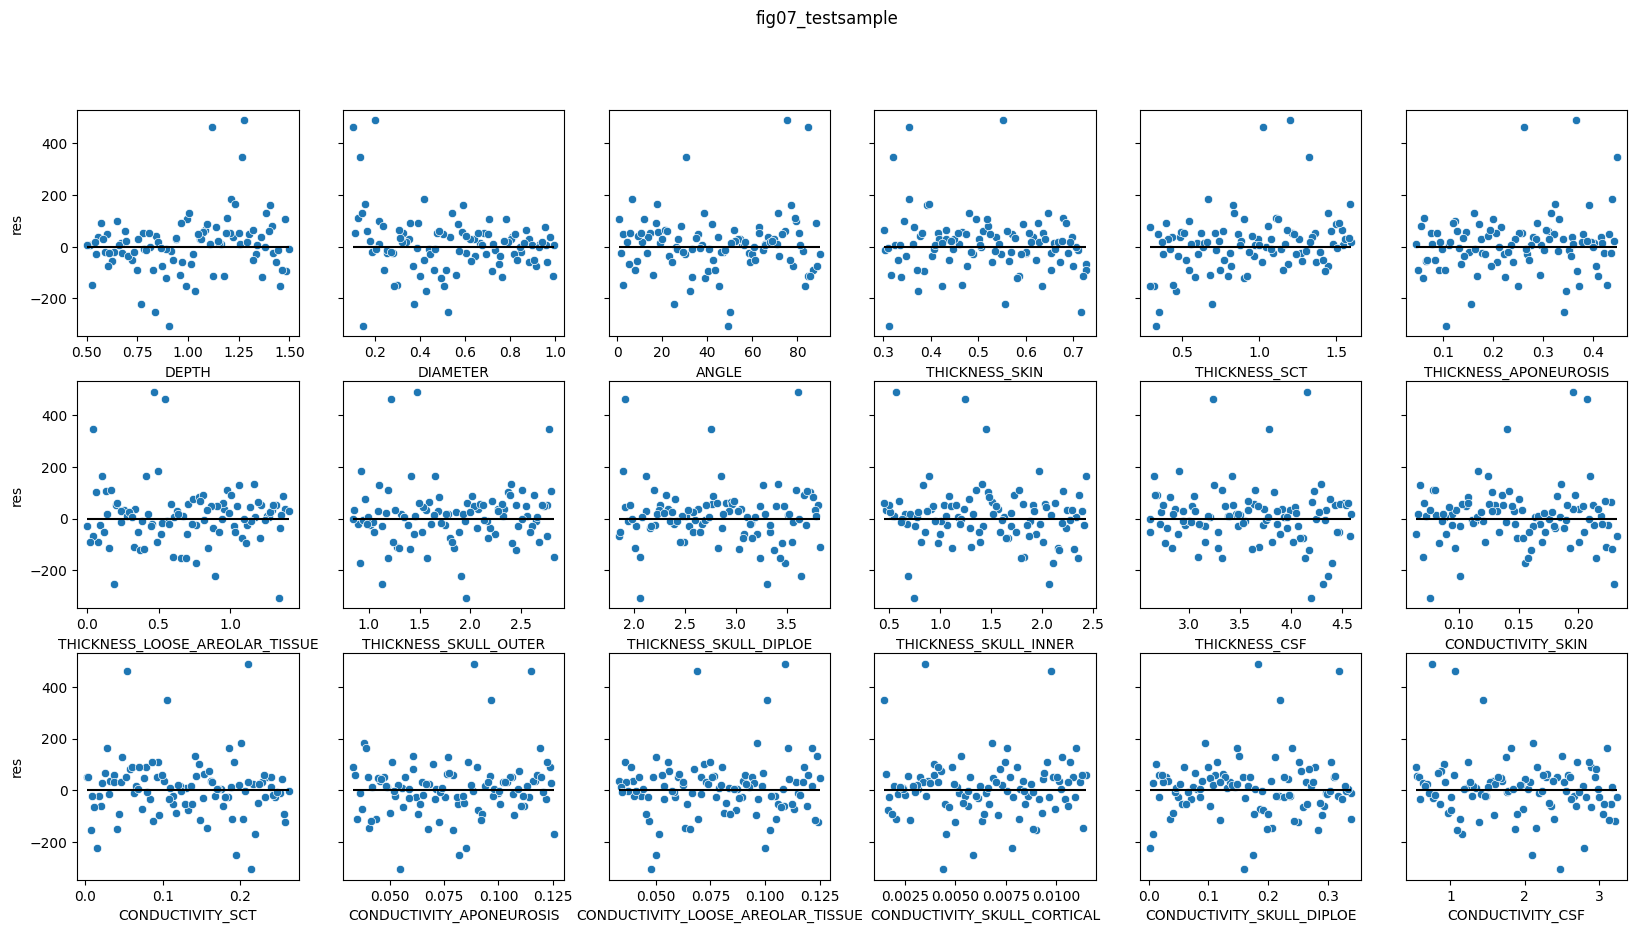

In [12]:
title = "fig07_testsample"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="res", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

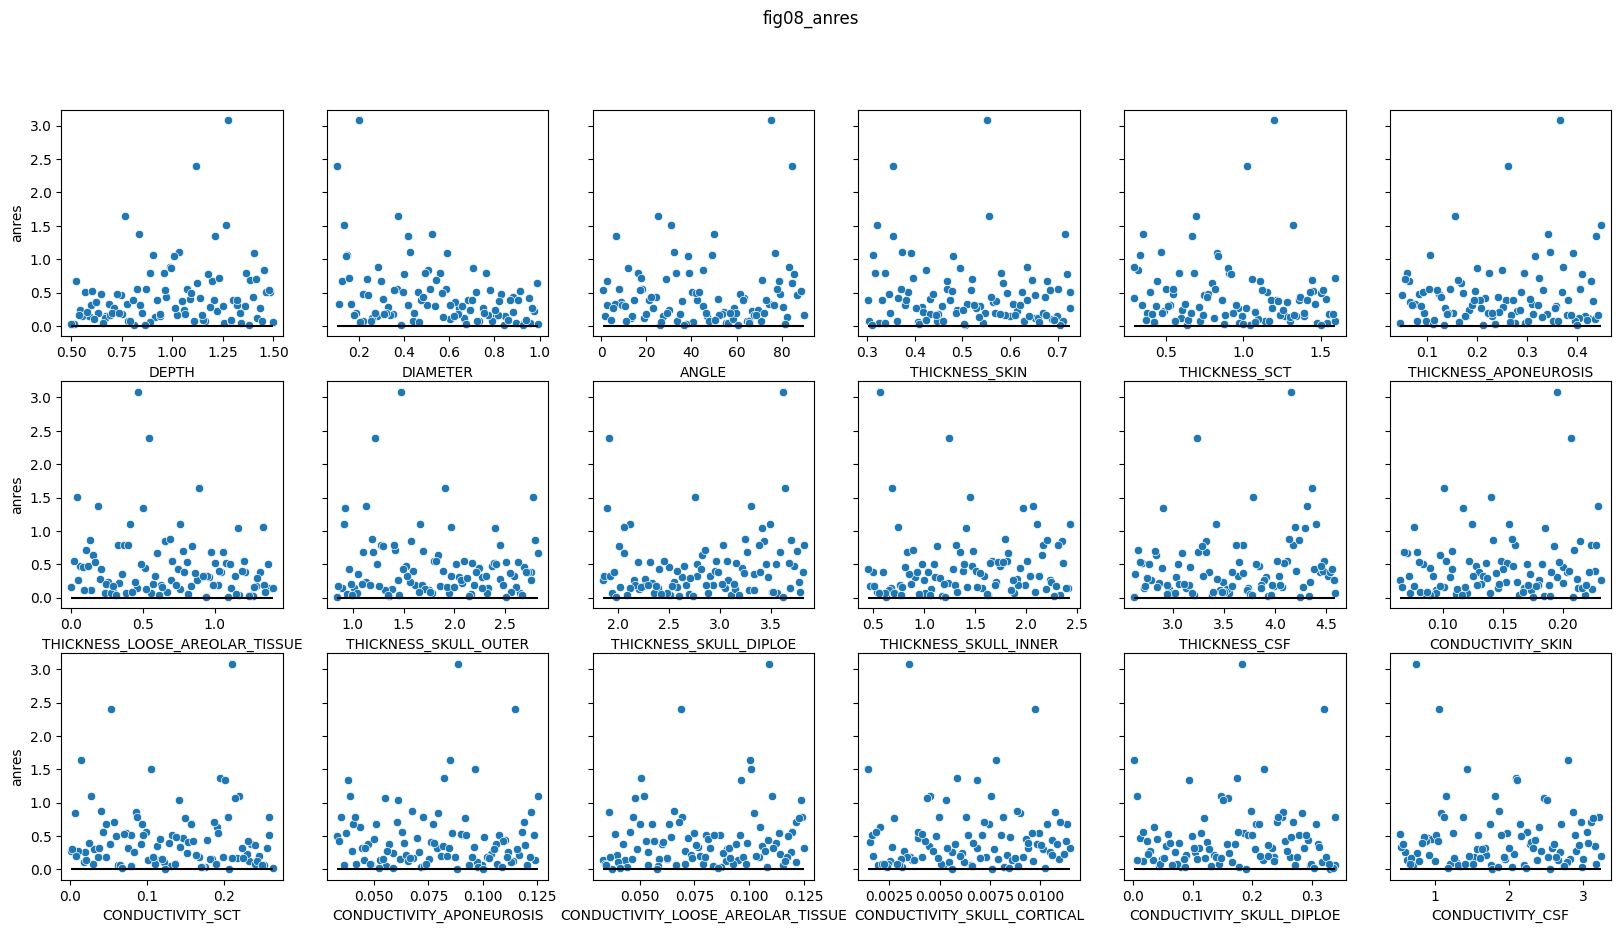

In [13]:
title = "fig08_anres"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="anres", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()